In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table
import scipy
from scipy.spatial import cKDTree
from tqdm import tqdm

In [14]:
def get_lsst_cat_ras_decs(lsst_cat, cat_type):
    lsst_df = pd.DataFrame()
    ra_dec_df = None
    if cat_type == 'truth':
        lsst_df = lsst_cat[(lsst_cat['mag_i'] < 27) & (lsst_cat['mag_r'] < 26.9)]
        ra_dec_df = lsst_df[['ra_truth_merged', 'dec_truth_merged']]
        ra_dec_df = ra_dec_df.rename(columns={'ra_truth_merged': 'ra', 'dec_truth_merged': 'dec'})
        mags = lsst_df['mag_i']
    else:  # for detection catalog
        lsst_df = lsst_cat[(lsst_cat['mag_i'] < 25.3)]
        ra_dec_df = lsst_df[['ra', 'dec']]
        mags = lsst_df['mag_i']
    return Table.from_pandas(ra_dec_df), list(mags)

In [15]:
dd_det_df = pd.read_json('lsst_runs/run4_ups_roman/dd_test_det.json')
lsst_test_truth = pd.read_json('lsst_test_truth_cat.json')
lsst_truth_table, test_truth_mags = get_lsst_cat_ras_decs(lsst_test_truth, cat_type='truth')
lsst_truth_df = lsst_truth_table.to_pandas()

In [16]:
# Confidence Calculation Methods
def method_random(detections, match_threshold, ground_truth_coords):
    """Assign random confidence scores."""
    return np.random.uniform(0.1, 1.0, len(detections))


def method_inverse_distance(detections, match_threshold, ground_truth_coords):
    """Confidence as the inverse of the minimum distance to any ground truth point."""
    confidences = []
    for det_coord in detections:
        separations = det_coord.separation(ground_truth_coords).arcsec
        min_distance = separations.min() if len(separations) > 0 else match_threshold
        confidences.append(1 / (1 + min_distance))
    return np.array(confidences)


def method_gaussian(detections, match_threshold, ground_truth_coords, sigma_arcsec=0.5):
    """Gaussian-based confidence calculation."""
    confidences = []
    for det_coord in detections:
        separations = det_coord.separation(ground_truth_coords).arcsec
        min_distance = separations.min() if len(separations) > 0 else match_threshold
        confidences.append(np.exp(-0.5 * (min_distance / sigma_arcsec) ** 2))
    return np.array(confidences)

# IoU Circle Area Calculation
def iou_circle_area(r1, r2, d):
    """Calculate IoU between two circles of radii r1 and r2 separated by distance d."""
    if d >= r1 + r2:
        return 0.0
    elif d <= abs(r1 - r2):
        return min(r1, r2) ** 2 / max(r1, r2) ** 2
    else:
        part1 = r1 ** 2 * np.arccos((d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1))
        part2 = r2 ** 2 * np.arccos((d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2))
        part3 = 0.5 * np.sqrt((-d + r1 + r2) * (d + r1 - r2) * (d - r1 + r2) * (d + r1 + r2))
        intersection_area = part1 + part2 - part3
        union_area = np.pi * (r1 ** 2 + r2 ** 2) - intersection_area
        return intersection_area / union_area

from scipy.spatial import cKDTree

def method_iou(detections, match_threshold, ground_truth_coords, iou_threshold=0.9):
    """
    IoU-based confidence calculation using KDTree for efficiency.
    """
    gt_tree = cKDTree(np.column_stack((ground_truth_coords.ra.deg, ground_truth_coords.dec.deg)))
    det_positions = np.column_stack((detections.ra.deg, detections.dec.deg))
    distances, indices = gt_tree.query(det_positions, distance_upper_bound=match_threshold.to(u.deg).value)
    
    confidences = []
    matched_gt_indices = set()  # Track matched ground truth indices
    
    for i, (distance, idx) in enumerate(zip(distances, indices)):
        # Handle unmatched detections
        if np.isinf(distance) or idx == len(ground_truth_coords):
            confidences.append(0)
            continue
        
        # Ensure the ground truth point isn't already matched
        if idx in matched_gt_indices:
            confidences.append(0)
            continue
        
        # Convert distance to arcseconds for IoU calculation
        arcsec_distance = distance * 3600  # Convert degrees to arcseconds
        iou = iou_circle_area(match_threshold.to_value(u.arcsec), match_threshold.to_value(u.arcsec), arcsec_distance)
         
        # Assign confidence if IoU meets the threshold
        if iou >= iou_threshold:
            matched_gt_indices.add(idx)
            confidences.append(iou)
        else:
            confidences.append(0)
    
    return np.array(confidences)


In [17]:
# Precision and Recall Calculation
def calculate_metrics_by_threshold(test_data, ground_truth, match_threshold, roi_thresholds, debug=False):
    """
    Calculates precision and recall across multiple ROI thresholds.
    """
    test_coords = SkyCoord(ra=test_data['ra'].values * u.deg, dec=test_data['dec'].values * u.deg)
    gt_coords = SkyCoord(ra=ground_truth['ra'].values * u.deg, dec=ground_truth['dec'].values * u.deg)

    precision_values, recall_values = [], []

    for threshold in roi_thresholds:
        # Filter predictions by confidence threshold
        filtered_predictions = test_data[test_data['confidence'] >= threshold]
        filtered_coords = SkyCoord(ra=filtered_predictions['ra'].values * u.deg, 
                                   dec=filtered_predictions['dec'].values * u.deg)

        # Initialize counts
        TP = 0  # True Positives
        FP = len(filtered_coords)  # False Positives (initially all detections)
        FN = len(gt_coords)  # False Negatives (initially all ground truth points)

        # Track matched detections
        matched_detections = set()

        for gt_coord in gt_coords:
            separations = gt_coord.separation(filtered_coords)
            within_threshold = separations.arcsec <= match_threshold.to(u.arcsec).value

            if np.any(within_threshold):
                closest_match_idx = np.argmin(separations.arcsec)
                if closest_match_idx not in matched_detections:
                    matched_detections.add(closest_match_idx)
                    TP += 1
                    FN -= 1
                    FP -= 1

        # Calculate precision and recall
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0

        precision_values.append(precision)
        recall_values.append(recall)

        if debug:
            print(f"Threshold: {threshold:.2f}, TP: {TP}, FP: {FP}, FN: {FN}, Precision: {precision:.3f}, Recall: {recall:.3f}")

    return precision_values, recall_values

In [18]:
# from scipy.spatial import cKDTree
# import numpy as np
# from tqdm import tqdm

# def calculate_metrics_by_threshold(test_data, ground_truth, match_threshold, roi_thresholds, debug=False):
#     """
#     Optimized calculation of precision and recall across multiple ROI thresholds.
#     """
#     # Convert RA/Dec to numpy arrays
#     test_coords = np.column_stack((test_data['ra'].values, test_data['dec'].values))
#     gt_coords = np.column_stack((ground_truth['ra'].values, ground_truth['dec'].values))
    
#     # Build cKDTree for ground truth coordinates
#     gt_tree = cKDTree(gt_coords)
    
#     precision_values, recall_values = [], []

#     # Loop over ROI thresholds
#     for threshold in tqdm(roi_thresholds, desc="Calculating Metrics for ROI Thresholds", leave=False):
#         Filter detections based on confidence
#         filtered_data = test_data[test_data['confidence'] >= threshold]
#         filtered_coords = np.column_stack((filtered_data['ra'].values, filtered_data['dec'].values))

#         if len(filtered_coords) == 0:
#             # If no detections remain after filtering
#             precision_values.append(0)
#             recall_values.append(0)
#             continue

#         # Query the nearest ground truth for each detection
#         distances, gt_indices = gt_tree.query(filtered_coords, distance_upper_bound=match_threshold.to_value(u.deg))
#         distances = distances * 3600  # Convert distances from degrees to arcseconds

#         # True Positives (detections matched to ground truth within the threshold)
#         tp_mask = distances <= match_threshold.to_value(u.arcsec)
#         TP = np.sum(tp_mask)

#         # False Positives (detections not matched to ground truth)
#         FP = len(filtered_coords) - TP

#         # False Negatives (ground truth points not matched to any detection)
#         matched_gt_indices = gt_indices[tp_mask]
#         FN = len(gt_coords) - len(np.unique(matched_gt_indices[matched_gt_indices != len(gt_coords)]))

#         # Calculate precision and recall
#         precision = TP / (TP + FP) if (TP + FP) > 0 else 0
#         recall = TP / (TP + FN) if (TP + FN) > 0 else 0

#         precision_values.append(precision)
#         recall_values.append(recall)

#         if debug:
#             print(f"Threshold: {threshold:.2f}, TP: {TP}, FP: {FP}, FN: {FN}, Precision: {precision:.3f}, Recall: {recall:.3f}")

#     return precision_values, recall_values


In [19]:
# Main Function
def compare_confidence_methods(test_data, ground_truth, match_threshold, roi_thresholds):
    """
    Compare precision and recall across different confidence methods.
    """
    methods = {
        #"Random Confidence": method_random,
        "Inverse Distance": method_inverse_distance,
        "Gaussian Confidence": method_gaussian,
        "IoU Matching": lambda det, mt, gt: method_iou(det, mt, gt, iou_threshold=0.5),

    }

    results = {}
    for method_name, method_function in tqdm(methods.items(), desc="Running Confidence Methods", leave=False):
        print(f"Running {method_name}...")
        # Calculate confidence scores
        test_coords = SkyCoord(ra=test_data['ra'].values * u.deg, dec=test_data['dec'].values * u.deg)
        ground_truth_coords = SkyCoord(ra=ground_truth['ra'].values * u.deg, dec=ground_truth['dec'].values * u.deg)
        test_data['confidence'] = method_function(test_coords, match_threshold, ground_truth_coords)
        
        # Compute metrics
        precision, recall = calculate_metrics_by_threshold(test_data, ground_truth, match_threshold, roi_thresholds, debug=True)
        results[method_name] = {"precision": precision, "recall": recall}
    
    return results

In [20]:
# Visualization
def plot_comparison(results, roi_thresholds):
    """
    Plot precision and recall for each confidence method.
    """
    plt.figure(figsize=(12, 8))
    
    for method_name, metrics in results.items():
        plt.plot(roi_thresholds, metrics["precision"], label=f"{method_name} - Precision", linestyle="--", marker="o")
        plt.plot(roi_thresholds, metrics["recall"], label=f"{method_name} - Recall", linestyle="-", marker="x")
    
    plt.title("Precision and Recall Comparison Across Confidence Methods")
    plt.xlabel("ROI Threshold")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.show()

In [21]:
def plot_comparison_individual(results, roi_thresholds):
    """
    Plot individual precision vs. recall graphs for each confidence method.
    """
    for method_name, metrics in results.items():
        plt.figure(figsize=(8, 6))
        plt.plot(metrics["recall"], metrics["precision"], label=f"{method_name}", linestyle="-", marker="o")
        plt.title(f"Precision vs. Recall for {method_name}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()
        plt.grid()
        plt.show()


Running Confidence Methods:   0%|          | 0/3 [00:00<?, ?it/s]

Running Inverse Distance...
Threshold: 0.05, TP: 16305, FP: 5958, FN: 1840, Precision: 0.732, Recall: 0.899
Threshold: 0.16, TP: 16305, FP: 5409, FN: 1840, Precision: 0.751, Recall: 0.899
Threshold: 0.26, TP: 16305, FP: 3108, FN: 1840, Precision: 0.840, Recall: 0.899
Threshold: 0.37, TP: 16278, FP: 1320, FN: 1867, Precision: 0.925, Recall: 0.897
Threshold: 0.47, TP: 16180, FP: 546, FN: 1965, Precision: 0.967, Recall: 0.892
Threshold: 0.58, TP: 15847, FP: 229, FN: 2298, Precision: 0.986, Recall: 0.873
Threshold: 0.68, TP: 14798, FP: 87, FN: 3347, Precision: 0.994, Recall: 0.816
Threshold: 0.79, TP: 10916, FP: 24, FN: 7229, Precision: 0.998, Recall: 0.602
Threshold: 0.89, TP: 4550, FP: 1, FN: 13595, Precision: 1.000, Recall: 0.251


Running Confidence Methods:  33%|███▎      | 1/3 [12:58<25:56, 778.36s/it]

Threshold: 1.00, TP: 0, FP: 0, FN: 18145, Precision: 0.000, Recall: 0.000
Running Gaussian Confidence...
Threshold: 0.05, TP: 16210, FP: 652, FN: 1935, Precision: 0.961, Recall: 0.893
Threshold: 0.16, TP: 16116, FP: 391, FN: 2029, Precision: 0.976, Recall: 0.888
Threshold: 0.26, TP: 15997, FP: 288, FN: 2148, Precision: 0.982, Recall: 0.882
Threshold: 0.37, TP: 15801, FP: 218, FN: 2344, Precision: 0.986, Recall: 0.871
Threshold: 0.47, TP: 15564, FP: 170, FN: 2581, Precision: 0.989, Recall: 0.858
Threshold: 0.58, TP: 15204, FP: 111, FN: 2941, Precision: 0.993, Recall: 0.838
Threshold: 0.68, TP: 14530, FP: 73, FN: 3615, Precision: 0.995, Recall: 0.801
Threshold: 0.79, TP: 13103, FP: 43, FN: 5042, Precision: 0.997, Recall: 0.722
Threshold: 0.89, TP: 9701, FP: 17, FN: 8444, Precision: 0.998, Recall: 0.535


Running Confidence Methods:  67%|██████▋   | 2/3 [25:39<12:48, 768.19s/it]

Threshold: 1.00, TP: 0, FP: 0, FN: 18145, Precision: 0.000, Recall: 0.000
Running IoU Matching...
Threshold: 0.05, TP: 16048, FP: 12, FN: 2097, Precision: 0.999, Recall: 0.884
Threshold: 0.16, TP: 16048, FP: 12, FN: 2097, Precision: 0.999, Recall: 0.884
Threshold: 0.26, TP: 16048, FP: 12, FN: 2097, Precision: 0.999, Recall: 0.884
Threshold: 0.37, TP: 16048, FP: 12, FN: 2097, Precision: 0.999, Recall: 0.884
Threshold: 0.47, TP: 16048, FP: 12, FN: 2097, Precision: 0.999, Recall: 0.884
Threshold: 0.58, TP: 15809, FP: 9, FN: 2336, Precision: 0.999, Recall: 0.871
Threshold: 0.68, TP: 15033, FP: 2, FN: 3112, Precision: 1.000, Recall: 0.828
Threshold: 0.79, TP: 12368, FP: 0, FN: 5777, Precision: 1.000, Recall: 0.682
Threshold: 0.89, TP: 6051, FP: 0, FN: 12094, Precision: 1.000, Recall: 0.333


Threshold: 1.00, TP: 0, FP: 0, FN: 18145, Precision: 0.000, Recall: 0.000


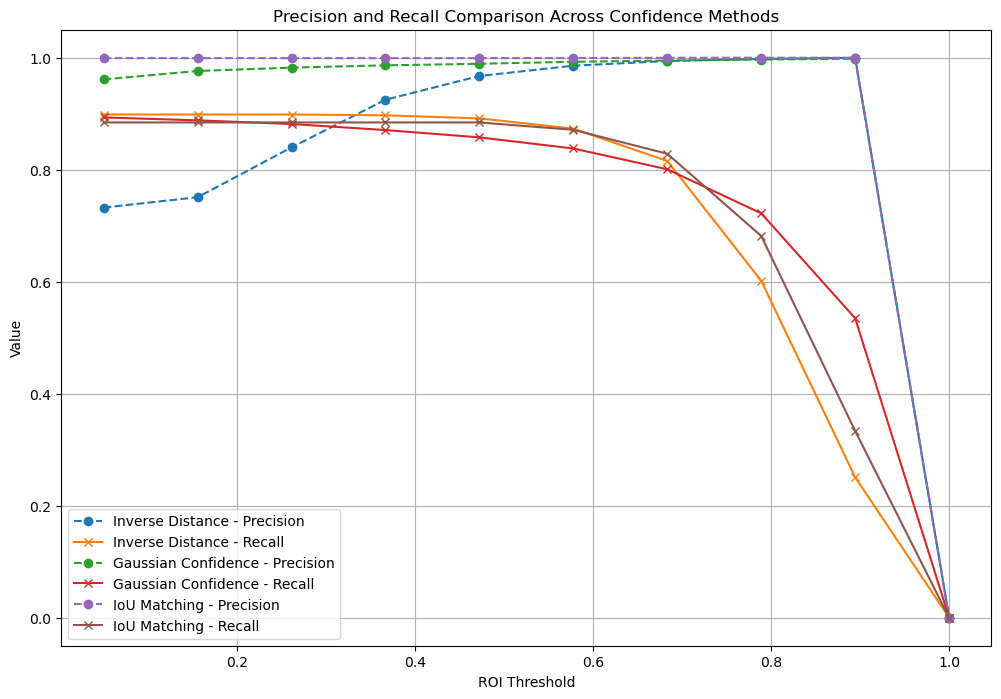

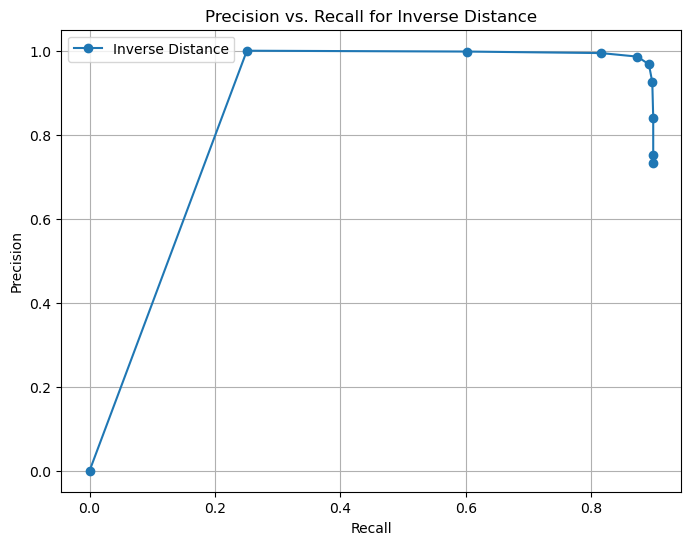

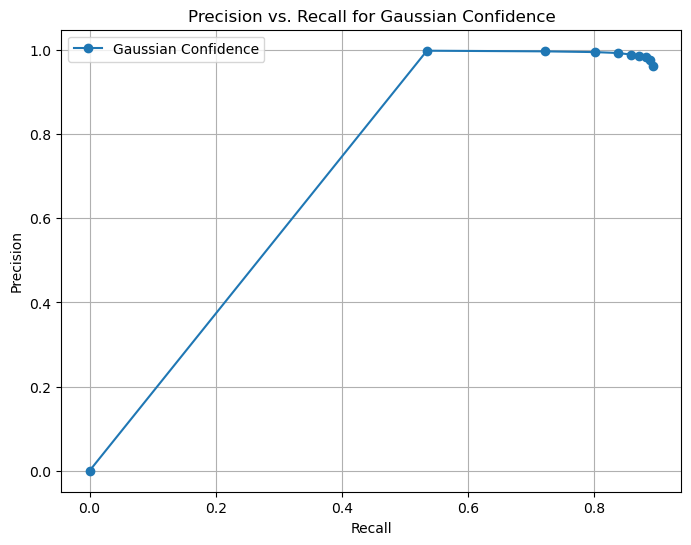

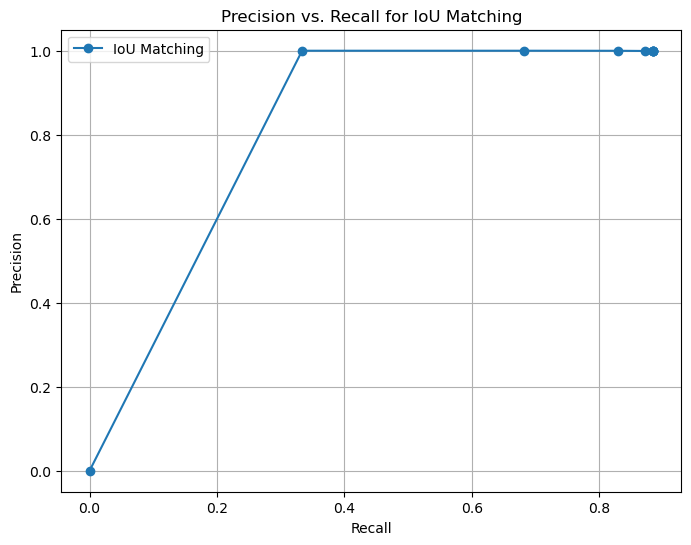

In [22]:
roi_thresholds = np.linspace(0.05, 1.0, 10)
match_threshold = 2 * u.arcsec  # threshold

results = compare_confidence_methods(dd_det_df, lsst_truth_df, match_threshold, roi_thresholds)
plot_comparison(results, roi_thresholds)
plot_comparison_individual(results, roi_thresholds)

In [ ]:
lsst_truth_df = pd.read_json('lsst_catalogs/full_lsst_truth_cat_no_gal_morph.json')
print(lsst_truth_df.head)